In [1]:
import numpy as np
import itertools as it

from helpers import *
from csv_helpers import list_to_csv

from tqdm import tqdm_notebook as tqdm
from implementations import *
from cross_validation import *
from feature_eng import *
from tuning import *
from data_cleaning import replace_invalid
from plots import display_features
from params_extracting import build_combinations, build_xs_mask

import matplotlib.pyplot as plt
# Turn interactive plotting off
plt.ioff()

In [2]:
y, x_brute_train, _ = load_csv_data("../data/train.csv")

In [3]:
_, x_brute_test, indices_test = load_csv_data("../data/test.csv")

In [4]:
y.shape, x_brute_train.shape, x_brute_test.shape

((250000,), (250000, 30), (568238, 30))

In [5]:
train_size = x_brute_train.shape[0]
test_size = x_brute_test.shape[0]

train_size, test_size

(250000, 568238)

In [6]:
x_brute = np.concatenate((x_brute_train, x_brute_test))
x_brute.shape

(818238, 30)

In [7]:
features_name = ["DER_mass_MMC","DER_mass_transverse_met_lep","DER_mass_vis","DER_pt_h","DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_deltar_tau_lep","DER_pt_tot","DER_sum_pt","DER_pt_ratio_lep_tau","DER_met_phi_centrality","DER_lep_eta_centrality","PRI_tau_pt","PRI_tau_eta","PRI_tau_phi","PRI_lep_pt","PRI_lep_eta","PRI_lep_phi","PRI_met","PRI_met_phi","PRI_met_sumet","PRI_jet_num","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi","PRI_jet_all_pt"]

In [8]:
DER_features = [i for i, f in enumerate(features_name) if ("DER_" in f)]

DER_features

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [9]:
PHI_features = [i for i, f in enumerate(features_name) if ("_phi" in f) and ("_phi_" not in f)]

PHI_features

[15, 18, 20, 25, 28]

# Data Cleaning

In [10]:
mask_invalid = x_brute != -999.0

Features with invalid values

In [11]:
features_with_invalid = [(i, num / (train_size + test_size) * 100)  for i, num in enumerate((~mask_invalid).sum(axis=0).tolist()) if num > 0]
features_with_invalid

[(0, 15.228087671313236),
 (4, 70.91494161845331),
 (5, 70.91494161845331),
 (6, 70.91494161845331),
 (12, 70.91494161845331),
 (23, 40.00926380832961),
 (24, 40.00926380832961),
 (25, 40.00926380832961),
 (26, 70.91494161845331),
 (27, 70.91494161845331),
 (28, 70.91494161845331)]

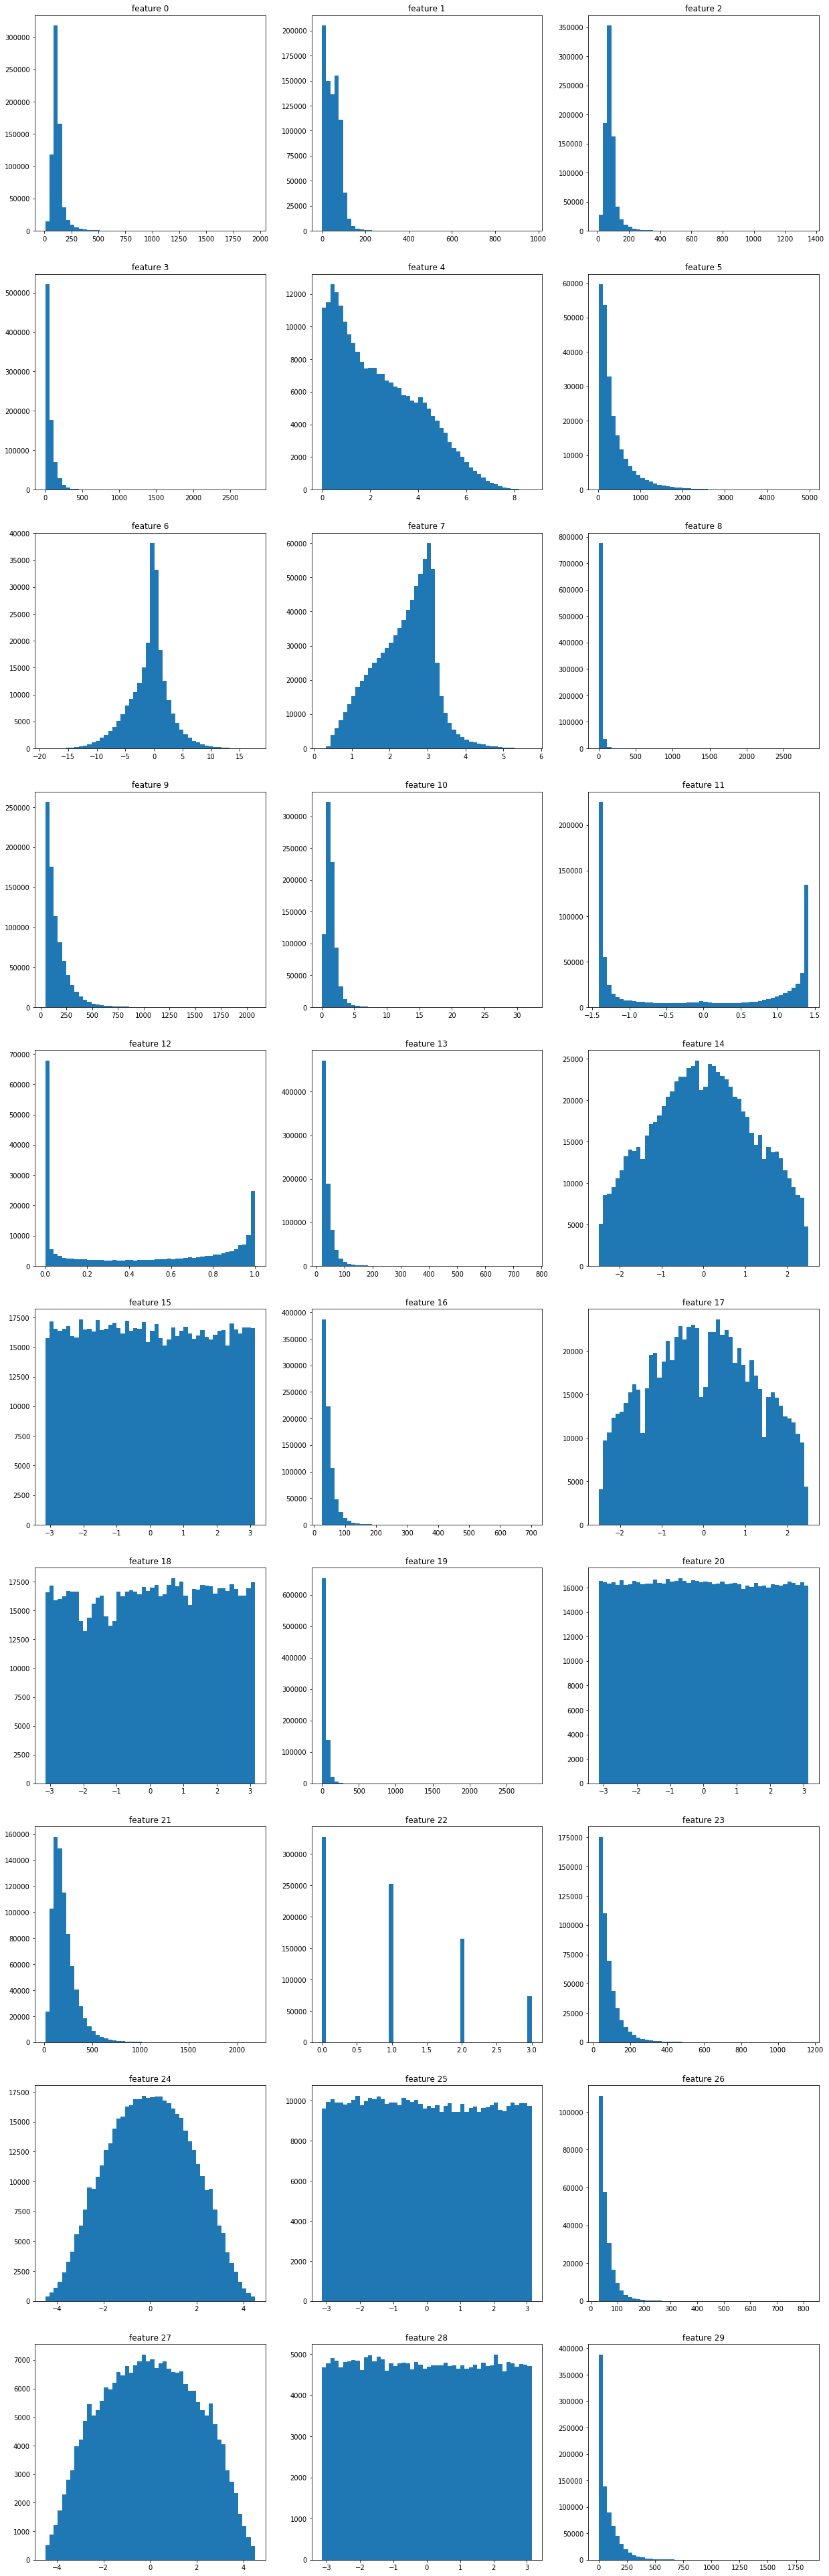

In [12]:
display_features(x_brute, mask_invalid, bins=50)

# Conditioning

In [13]:
def verify_masks(masks):
    total = 0
    for mask in masks:
        num = mask.sum()
        print(num)
        total += num
    assert total == x_brute.shape[0]
    return len(masks)

## Conditioning on invalid features

In [14]:
def mask_feat_i_invalid(i):
    return [
    x_brute[:, i] == -999.0,
    x_brute[:, i] != -999.0
]

In [15]:
verify_masks(mask_feat_i_invalid(4))

580253
237985


2

## Masks choosen


In [16]:
data_masks = []
for mask_i in mask_feat_i_invalid(4):
    for mask_j in  mask_feat_i_invalid(23):
        mask = mask_i & mask_j
        if mask.sum() > 0:
            data_masks.append(mask)
        
verify_masks(data_masks)

327371
252882
237985


3

### Mask on Y

In [17]:
ys = [y[mask[:train_size]] for mask in data_masks]

[y.shape for y in ys]

[(99913,), (77544,), (72543,)]

### Mask on X

In [18]:
feature_masks = [x_brute[m].std(axis=0) != 0 for m in data_masks]

In [19]:
x_replaced_invalid = replace_invalid(x_brute, mask_invalid, replace_by="mf")
xs_replace_invalid = [x_replaced_invalid[mask] for mask in data_masks]

[x.shape for x in xs_replace_invalid]

[(327371, 30), (252882, 30), (237985, 30)]

In [20]:
xs_cleaned = [x[:, m] for x, m in zip(xs_replace_invalid, feature_masks)]

[x.shape for x in xs_cleaned]

[(327371, 18), (252882, 22), (237985, 30)]

Angles!

In [21]:
mask_phi_features = range_mask(30, PHI_features)

In [22]:
xs_angles = [x[:, mask_phi_features[mask]] for x, mask in zip(xs_cleaned, feature_masks)]
xs_no_angles = [x[:, ~mask_phi_features[mask]] for x, mask in zip(xs_cleaned, feature_masks)]

[x.shape for x in xs_angles], [x.shape for x in xs_no_angles]

([(327371, 3), (252882, 4), (237985, 5)],
 [(327371, 15), (252882, 18), (237985, 25)])

# Features Engineering

## Features with log

In [23]:
xs_non_negative = [x - x.min(axis=0) for x in xs_no_angles]

In [24]:
xs_log = [np.log(1 + x) for x in xs_non_negative]
    
[f.shape for f in xs_log]

[(327371, 15), (252882, 18), (237985, 25)]

In [25]:
xs_inv_log = [np.log(1 / (1 + x)) for x in xs_non_negative]
    
[f.shape for f in xs_inv_log]

[(327371, 15), (252882, 18), (237985, 25)]

In [26]:
xs_log_inv = [(1 / 1 + x) for x in xs_log]

[f.shape for f in xs_log_inv]

[(327371, 15), (252882, 18), (237985, 25)]

In [27]:
xs_inv = [1/(x + 1) for x in xs_non_negative]

[f.shape for f in xs_inv]

[(327371, 15), (252882, 18), (237985, 25)]

In [28]:
def xs_power(n, xs=xs_no_angles):
    return [np.power(x, n) for x in xs]

In [29]:
def xs_sqrt(n, xs=xs_non_negative):
    return [x**(1/n) for x in xs]

In [30]:
def create_poly_features(xs, degrees):
    return [build_poly(x, degree) for x, degree in tqdm(zip(xs, degrees), ncols=100)]

In [31]:
def fdif(xs1, xs2, filename):
    plot_mult_dif(ys, xs1, xs2, [5e-04] * 3, filename=filename+"_10", iters=10)

In [32]:
def fimpr(xs1, xs2, filename):
    plot_mult_impr(ys, xs1, xs2, [5e-04] * 3, filename=filename+"_10", iters=10)

In [33]:
def mit(x1, x2):
    return [np.concatenate(x, axis=1) for x in zip(x1, x2)]

In [34]:
'''
fimpr(xs_no_angles, xs_angles, "no_angles-and-angles")
fdif(xs_cleaned, xs_no_angles, filename="cleaned-vs-no_angles")
fimpr(xs_no_angles, xs_log, filename="no_angles-and-log")
fimpr(xs_no_angles, xs_log_inv, filename="no_angles-and-log_inv")
fimpr(xs_no_angles, xs_inv_log, filename="no_angles-and-inv_log")
fimpr(xs_no_angles, xs_inv, filename="no_angles-and-inv")
for i in range(2, 15):
    fimpr(xs_no_angles, xs_power(i), filename="no_angles-and-power_{}".format(i))
    fimpr(xs_no_angles, xs_power(i, xs_log), filename="log-and-power_{}".format(i))
    fimpr(xs_no_angles, xs_power(i, xs_inv_log), filename="inv_log-and-power_{}".format(i))
    fimpr(xs_no_angles, xs_sqrt(i), filename="no_angles-and-sqrt_{}".format(i))
fimpr(mit(xs_no_angles, xs_log), xs_inv_log, "no_angles_with_log-and-inv_log")
fimpr(mit(xs_no_angles, xs_inv_log), xs_log, "no_angles_with_inv_log-and_log")
fimpr(mit(xs_no_angles, xs_log_inv), xs_log, "no_angles_with_log_inv-and-log")
fimpr(mit(xs_no_angles, xs_log), xs_log_inv, "no_angles_with_log-and-log_inv")
fimpr(mit(xs_no_angles, xs_inv_log), xs_log_inv, "no_angles_with_inv_log-and-log_inv")
fimpr(mit(xs_no_angles, xs_log_inv), xs_inv_log, "no_angles_with_log_inv-and-inv_log")
'''

#fdif([build_poly(x, 7)[:, 1:] for x in xs_no_angles], [build_poly(standardize(x), 7)[:, 1:] for x in xs_no_angles], "no_angles_poly_7-standardization(inside)")


plt.show()

In [35]:
'''
# find useless features from xs_mix
for _ in range(7):
    find_useless_features(ys, xs_mix, [1e-04]*3, filename="xs_mix")
    
# combinations for functions
find_best_combinations(ys, xs_mix, [1e-04]*3, [np.multiply, lambda a, b: np.abs(a - b)], ["mult", "abs_sub"])

# find useless poly features
for _ in range(3):
    find_useless_features(ys, poly_features_featuresy_featuresy_featuresy_features, [1e-04]*3, filename="poly_features")
'''
;

''

## Standardization of the data

## Polynomial features

In [36]:
degrees_no_angles = [6, 11, 11]
poly_no_angles = create_poly_features([standardize(x) for x in xs_no_angles], degrees_no_angles)

[x.shape for x in poly_no_angles]

3it [00:05,  1.99s/it]


[(327371, 90), (252882, 198), (237985, 275)]

In [37]:
degrees_roots_no_angles = [5, 5, 5]
poly_roots_no_angles = [np.concatenate([(x + 100) ** (1/deg) for deg in range(2, max_deg + 1)], axis=1) for x, max_deg in zip(xs_no_angles, degrees_roots_no_angles)]

[x.shape for x in poly_roots_no_angles]

[(327371, 60), (252882, 72), (237985, 100)]

In [38]:
degrees_log = [5, 5, 5]
poly_log = create_poly_features([standardize(x) for x in xs_log], degrees_log)

[x.shape for x in poly_log]

3it [00:02,  1.06it/s]


[(327371, 75), (252882, 90), (237985, 125)]

In [39]:
degrees_inv_log = [5, 5, 5]
poly_inv_log = create_poly_features([standardize(x) for x in xs_inv_log], degrees_inv_log)

[x.shape for x in poly_inv_log]

3it [00:02,  1.07it/s]


[(327371, 75), (252882, 90), (237985, 125)]

In [40]:
xs_poly = [np.concatenate(x, axis=1) for x in zip(poly_no_angles, poly_roots_no_angles, poly_log, poly_inv_log)]

[x.shape for x in xs_poly]

[(327371, 300), (252882, 450), (237985, 625)]

for i in range(4, 14):
    plot_mult_dif(ys, create_poly_features(poly_no_angles, [i] * 3), create_poly_features(poly_no_angles, [i+1] * 3), lambdas, filename="poly_no_angles-{i}-vs-{j}".format(i=i, j=i+1))
    plot_mult_dif(ys, create_poly_features(poly_log, [i] * 3), create_poly_features(poly_log, [i+1] * 3), lambdas, filename="poly_log-{i}-vs-{j}".format(i=i, j=i+1))    
    plot_mult_dif(ys, create_poly_features(poly_inv_log, [i] * 3), create_poly_features(poly_inv_log, [i+1] * 3), lambdas, filename="poly_inv_log-{i}-vs-{j}".format(i=i, j=i+1))    

## Combinations of features

In [41]:
def all_combinations_of(xs, fn, combs):
    combinations = []
    for i, pairs in tqdm(list(enumerate(combs)), ncols=100):
        combinations.append(combinations_of(xs[i], fn, pairs))
    return combinations

def combinations_of(x, fn, pairs):
    if len(pairs) > 0:
        combinations = [fn(x[:, int(a)], x[:, int(b)]).reshape((x.shape[0], 1)) for a, b in pairs]
        return np.concatenate(combinations, axis=1)
    return np.array([])

In [42]:
xs_standardized = [ np.concatenate([standardize(x) for x in xx], axis=1) for xx in zip(xs_no_angles, xs_log, xs_inv_log)]

[f.shape for f in xs_standardized]

[(327371, 45), (252882, 54), (237985, 75)]

In [43]:
functions = {
    #"mult": np.multiply,
    "mult_square": lambda a,b: np.power(a, 2) * np.power(b, 2),
    "abs_sub": lambda a,b: np.abs(a - b),
}

In [44]:
features_combs = {}
for fn_name in functions.keys():
    fn_combinations = [index_combinations(x.shape[1], x.shape[1]) for x in xs_standardized]#build_combinations(fn_name, -1, len(data_masks))
    print(fn_name + ": {}".format([len(c) for c in fn_combinations]))
    features_combs[fn_name] = all_combinations_of(xs_standardized, functions[fn_name], fn_combinations)

mult: [990, 1431, 2775]


100%|█████████████████████████████████████████████████████████████████| 3/3 [01:10<00:00, 23.62s/it]


abs_sub: [990, 1431, 2775]


100%|█████████████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.34s/it]


In [45]:
[x.shape for x in features_combs["mult"]], [x.shape for x in features_combs["abs_sub"]]

([(327371, 990), (252882, 1431), (237985, 2775)],
 [(327371, 990), (252882, 1431), (237985, 2775)])

In [46]:
ones_features = [np.ones(m.sum()).reshape((m.sum(), 1)) for m in data_masks]

[x.shape for x in ones_features]

[(327371, 1), (252882, 1), (237985, 1)]

## Concat all features

In [47]:
all_features = zip(
    ones_features,
    xs_poly,
    features_combs["mult"],
    features_combs["abs_sub"]
)

features = [np.concatenate([f for f in list(fs) if len(f) > 0], axis=1) for fs in tqdm(list(all_features), ncols=100)]

[f.shape for f in features]

100%|█████████████████████████████████████████████████████████████████| 3/3 [04:28<00:00, 89.63s/it]


[(327371, 2281), (252882, 3313), (237985, 6176)]

# Separating Training and Test data

In [48]:
xs_train, xs_test = separate_train(features, train_size, data_masks)

[(tr.shape, te.shape) for tr, te in zip(xs_train, xs_test)]

[((99913, 2281), (227458, 2281)),
 ((77544, 3313), (175338, 3313)),
 ((72543, 6176), (165442, 6176))]

# Cross validation

In [50]:
k_fold = 4
iters = 1

lambdas = [1e-04] * 3 #[1e-05, 1e-05, 1e-05]
seed = np.random.randint(10000)

scores = cv_with_list(ys, xs_train, lambdas, k_fold=k_fold, iters=iters, seed=seed, print_=True)

final_score = np.sum([score*x.shape[0]/train_size for score, x in zip(scores.mean(axis=0), xs_train)])
print("Final Test Error = {}".format(final_score * 100))


MemoryError: 

# Submission

In [52]:
def pred_ridge_with_conditioning(ys, xs_train, xs_test, lambdas):
    y_sub = np.zeros(np.sum([x.shape[0] for x in xs_test]))
    for y, x_tr, x_te, lambda_, mask in zip(ys, xs_train, xs_test, lambdas, data_masks):
        w = ridge_regression(y, x_tr, lambda_)
        y_sub_part = predict_labels(w, x_te)
        y_sub[mask[train_size:]] = y_sub_part
    return y_sub

In [ ]:
#rigde
y_submission = pred_ridge_with_conditioning(ys, xs_train, xs_test, lambdas)

#logistic
# w_submission, _ = logistic_regression(y_train, x_train, initial_w, max_iters, gamma)
# y_submission = predict_labels(w, x_test)

In [ ]:
create_csv_submission(indices_test, y_submission, "submissions/pred26.csv")